# Классификация банковских запросов 🏦

## Введение

В этом ноутбуке мы познакомимся с задачей **классификации интентов** - определения намерений пользователя по его текстовому запросу. Это одна из ключевых задач в создании чат-ботов и голосовых ассистентов.

**Наша задача:** по текстовому запросу клиента банка определить, к какой категории (интенту) он относится. Например:
- "How do I activate my card?" → `activate_my_card`
- "What is my balance?" → `balance`
- "I want to transfer money" → `transfer`

**Что мы изучим:**
- Загрузку датасета Banking77 с 77 различными интентами
- Классический подход: Count Vectorizer (Bag of Words) + Логистическая регрессия
- Современный подход: Sentence Transformers (семантические эмбеддинги) + Логистическая регрессия
- Визуализацию эмбеддингов с помощью t-SNE
- Сравнение двух подходов

**Датасет Banking77:**
- 13,083 запросов клиентов банка на английском языке
- 77 категорий интентов (activate_my_card, age_limit, apple_pay_or_google_pay и т.д.)
- Реальные примеры вопросов к банковскому чат-боту


## 1. Импорт библиотек


In [1]:
# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для машинного обучения
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# Библиотека для загрузки датасета
from datasets import load_dataset

# Библиотека для sentence embeddings
from sentence_transformers import SentenceTransformer

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

print("✅ Все библиотеки успешно загружены!")


✅ Все библиотеки успешно загружены!


In [2]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 2. Загрузка датасета Banking77


Датасет Banking77 содержит запросы к банковскому чат-боту, разбитые на 77 различных категорий (интентов).

Каждый интент представляет собой определенное намерение клиента:
- **activate_my_card** - активация карты
- **balance** - проверка баланса
- **transfer** - перевод денег
- **card_payment_wrong_exchange_rate** - жалоба на неправильный обменный курс
- и т.д.

Загрузим датасет с помощью библиотеки `datasets` от Hugging Face:


In [3]:
# Загружаем датасет Banking77
dataset = load_dataset("DeepPavlov/banking77")

print("✅ Датасет успешно загружен!")
print("\nСтруктура датасета:")
print(dataset)


✅ Датасет успешно загружен!

Структура датасета:
DatasetDict({
    train: Dataset({
        features: ['utterance', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['utterance', 'label'],
        num_rows: 3080
    })
})


## 3. Исследование данных


In [4]:
# Преобразуем в pandas DataFrame для удобства
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print("📊 Базовая статистика:")
print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")
print(f"Количество уникальных интентов: {train_df['label'].nunique()}")
print("\nПервые 5 примеров:")
print(train_df.head())


📊 Базовая статистика:
Размер обучающей выборки: 10003
Размер тестовой выборки: 3080
Количество уникальных интентов: 77

Первые 5 примеров:
                                           utterance  label
0   Please help me with my card.  It won't activate.      0
1         I tired but an unable to activate my card.      0
2                     I want to start using my card.      0
3                       How do I verify my new card?      0
4  I tried activating my plug-in and it didn't pi...      0


Посмотрим на примеры запросов из разных категорий:


In [5]:
# Посмотрим на примеры из разных интентов
np.random.seed(42)
sample_labels = np.random.choice(train_df['label'].unique(), 5, replace=False)

print("🔍 Примеры запросов из разных интентов:\n")
for label in sample_labels:
    examples = train_df[train_df['label'] == label]['utterance'].values[:2]
    print(f"Интент {label}:")
    for i, text in enumerate(examples, 1):
        print(f"  {i}. {text}")
    print()


🔍 Примеры запросов из разных интентов:

Интент 4:
  1. Can I add money automatically to my account while traveling?
  2. i need help finding the auto top up option.

Интент 35:
  1. What is happening?  I have tried to transfer money 5x already.  Is the system down?  This shouldnt be happening as this is a basic transfer.
  2. Is there a reason that my transfer failed?

Интент 10:
  1. Is there anywhere I can't use my card?
  2. In which stores can I shop with this card?

Интент 0:
  1. Please help me with my card.  It won't activate.
  2. I tired but an unable to activate my card.

Интент 45:
  1. What does it mean when a payment is pending?
  2. Could you please tell me why my purchases from this morning say payment is pending?



Визуализируем распределение классов:


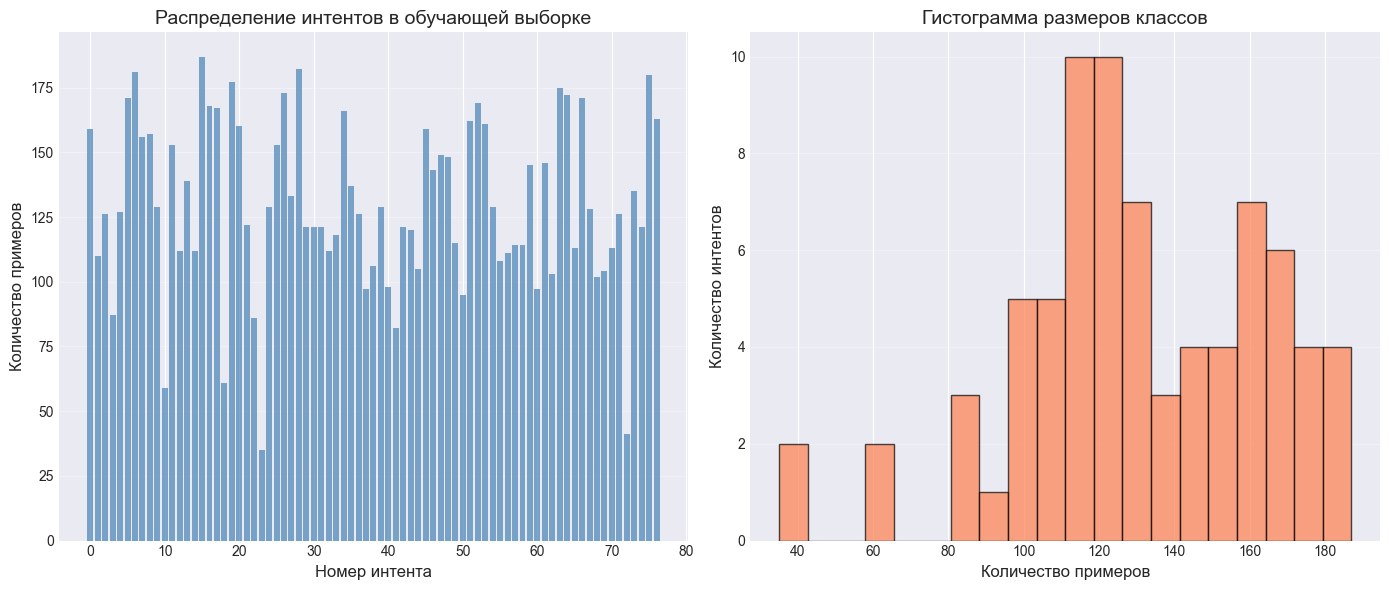

Средний размер класса: 129.9
Минимальный размер класса: 35
Максимальный размер класса: 187


In [6]:
# Распределение классов в обучающей выборке
plt.figure(figsize=(14, 6))

label_counts = train_df['label'].value_counts().sort_index()

plt.subplot(1, 2, 1)
plt.bar(range(len(label_counts)), label_counts.values, color='steelblue', alpha=0.7)
plt.xlabel('Номер интента', fontsize=12)
plt.ylabel('Количество примеров', fontsize=12)
plt.title('Распределение интентов в обучающей выборке', fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(label_counts.values, bins=20, color='coral', alpha=0.7, edgecolor='black')
plt.xlabel('Количество примеров', fontsize=12)
plt.ylabel('Количество интентов', fontsize=12)
plt.title('Гистограмма размеров классов', fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Средний размер класса: {label_counts.mean():.1f}")
print(f"Минимальный размер класса: {label_counts.min()}")
print(f"Максимальный размер класса: {label_counts.max()}")


Подготовим данные для обучения моделей:


In [7]:
# Выделяем признаки (тексты) и целевую переменную (метки классов)
X_train = train_df['utterance'].values
y_train = train_df['label'].values

X_test = test_df['utterance'].values
y_test = test_df['label'].values

print("✅ Данные подготовлены:")
print(f"   Обучающая выборка: {len(X_train)} запросов")
print(f"   Тестовая выборка: {len(X_test)} запросов")


✅ Данные подготовлены:
   Обучающая выборка: 10003 запросов
   Тестовая выборка: 3080 запросов


## 4. Базовый подход: Count Vectorizer + Логистическая регрессия 📊


### Что такое Count Vectorizer (Bag of Words)?

**Count Vectorizer** преобразует текст в числовой вектор, подсчитывая количество появлений каждого слова в тексте.

**Принцип работы:**
1. Создается словарь всех уникальных слов из всех текстов
2. Каждый текст представляется как вектор длиной, равной размеру словаря
3. В векторе на позиции каждого слова стоит количество его появлений в тексте

**Пример:**
- Словарь: ["активировать", "карту", "как", "мой", "баланс", "узнать"]
- Текст 1: "Как активировать мой карту" → [1, 1, 1, 1, 0, 0]
- Текст 2: "Как узнать мой баланс" → [0, 0, 1, 1, 1, 1]

**Преимущества:**
- Простой и быстрый
- Хорошо работает на небольших данных
- Интерпретируемый (можно увидеть важность слов)

**Недостатки:**
- Игнорирует порядок слов и контекст
- Не понимает синонимы ("активировать" ≠ "включить")
- Большая размерность при большом словаре


### 4.1. Векторизация текстов


In [8]:
# Создаем векторизатор
# max_features=5000 - берем только 5000 самых частых слов
# min_df=2 - игнорируем слова, встречающиеся меньше 2 раз
count_vectorizer = CountVectorizer(max_features=5000, min_df=2)

# Обучаем векторизатор на обучающей выборке и преобразуем тексты
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print("✅ Векторизация завершена!")
print(f"Размер словаря: {len(count_vectorizer.vocabulary_)}")
print(f"Размер обучающей матрицы: {X_train_counts.shape}")
print(f"Размер тестовой матрицы: {X_test_counts.shape}")
print("\nПример первых 10 слов из словаря:")
print(list(count_vectorizer.vocabulary_.keys())[:10])


✅ Векторизация завершена!
Размер словаря: 1461
Размер обучающей матрицы: (10003, 1461)
Размер тестовой матрицы: (3080, 1461)

Пример первых 10 слов из словаря:
['please', 'help', 'me', 'with', 'my', 'card', 'it', 'won', 'activate', 'tired']


### 4.2. Обучение модели


In [9]:
# Создаем и обучаем логистическую регрессию
lr_counts = LogisticRegressionCV(random_state=42)
lr_counts.fit(X_train_counts, y_train)

print("✅ Модель обучена!")


✅ Модель обучена!


### 4.3. Оценка качества


In [10]:
# Делаем предсказания
y_pred_counts = lr_counts.predict(X_test_counts)

# Считаем accuracy
accuracy_counts = accuracy_score(y_test, y_pred_counts)

print("📊 Результаты Count Vectorizer + Логистическая регрессия:")
print(f"Accuracy на тестовой выборке: {accuracy_counts:.4f} ({accuracy_counts*100:.2f}%)")
print(f"\nЭто означает, что модель правильно классифицировала {int(accuracy_counts*len(y_test))} из {len(y_test)} запросов")


📊 Результаты Count Vectorizer + Логистическая регрессия:
Accuracy на тестовой выборке: 0.8857 (88.57%)

Это означает, что модель правильно классифицировала 2728 из 3080 запросов


### 4.4. Анализ ошибок


In [11]:
# Найдем примеры неправильных предсказаний
errors_mask = y_test != y_pred_counts
errors_indices = np.where(errors_mask)[0]

print(f"🔍 Найдено {len(errors_indices)} ошибок. Рассмотрим несколько примеров:\n")

# Покажем 5 случайных ошибок
np.random.seed(42)
sample_errors = np.random.choice(errors_indices, min(5, len(errors_indices)), replace=False)

for idx in sample_errors:
    print(f"Текст: \"{X_test[idx]}\"")
    print(f"Истинный интент: {y_test[idx]}")
    print(f"Предсказанный интент: {y_pred_counts[idx]}")
    print()


🔍 Найдено 352 ошибок. Рассмотрим несколько примеров:

Текст: "What do I need to do to transfer my paycheck to my account?"
Истинный интент: 50
Предсказанный интент: 65

Текст: "I can't transfer money from my account."
Истинный интент: 27
Предсказанный интент: 65

Текст: "There is a fee on my account. Why?"
Истинный интент: 15
Предсказанный интент: 34

Текст: "What are your policies for card transfers?"
Истинный интент: 35
Предсказанный интент: 43

Текст: "How can I fix my card, it got declined twice."
Истинный интент: 27
Предсказанный интент: 63



## 5. Современный подход: Sentence Transformers 🤖


### Что такое Sentence Transformers?

**Sentence Transformers** - это библиотека, которая преобразует тексты в **семантические эмбеддинги** (векторные представления), которые отражают *смысл* текста, а не просто набор слов.

### Основные отличия от Count Vectorizer:

| Характеристика | Count Vectorizer | Sentence Transformers |
|----------------|------------------|----------------------|
| **Что кодирует** | Частоту слов | Смысл предложения |
| **Синонимы** | Разные векторы | Похожие векторы |
| **Порядок слов** | Не учитывает | Учитывает контекст |
| **Размер вектора** | Размер словаря (тысячи) | Фиксированный (обычно 384-768) |
| **Обучение** | Без обучения | Предобучены на больших данных |

### Как это работает?

**Count Vectorizer** просто считает слова:
- "Activate my card" → [1, 0, 1, 1, ...]
- "Enable my card" → [0, 1, 1, 1, ...]
- Векторы **разные**, хотя смысл одинаковый!

**Sentence Transformers** понимает смысл:
- "Activate my card" → [0.15, -0.32, 0.87, ...]
- "Enable my card" → [0.14, -0.31, 0.88, ...]
- Векторы **похожи**, потому что смысл одинаковый!

### Модель all-MiniLM-L6-v2

Мы будем использовать модель **all-MiniLM-L6-v2**:
- Компактная и быстрая модель (22 млн параметров)
- Создает векторы размерности 384
- Обучена на множестве задач понимания текста
- Хорошо работает для коротких текстов (как наши запросы)

### Преимущества:
- ✅ Понимает синонимы и перефразировки
- ✅ Учитывает контекст и порядок слов
- ✅ Фиксированный размер вектора (не зависит от словаря)
- ✅ Обобщает на новые слова

### Недостатки:
- ❌ Требует больше вычислительных ресурсов
- ❌ Менее интерпретируемый (сложно понять, почему модель так решила)
- ❌ Нужна предобученная модель


## 6. Визуализация эмбеддингов 📊


Чтобы лучше понять разницу между двумя подходами, давайте визуализируем эмбеддинги!

Мы используем **t-SNE** (t-distributed Stochastic Neighbor Embedding) - метод понижения размерности, который позволяет:
- Преобразовать высокоразмерные векторы в 2D пространство
- Сохранить структуру данных (похожие тексты останутся рядом)
- Наглядно увидеть, как модели группируют тексты

Для наглядности возьмем несколько интентов и посмотрим, как их распределяют оба подхода.


### 6.1. Подготовка данных для визуализации


In [12]:
# Выберем несколько интересных интентов для визуализации
selected_labels = [0, 5, 10, 15, 20, 25]  # 6 разных интентов
n_samples_per_label = 50  # по 50 примеров из каждого

# Отфильтруем данные
mask = train_df['label'].isin(selected_labels)
viz_df = train_df[mask].groupby('label').head(n_samples_per_label)

X_viz = viz_df['utterance'].values
y_viz = viz_df['label'].values

print(f"✅ Подготовлено {len(X_viz)} примеров для визуализации")
print(f"Выбранные интенты: {selected_labels}")


✅ Подготовлено 300 примеров для визуализации
Выбранные интенты: [0, 5, 10, 15, 20, 25]


### 6.2. Получение эмбеддингов


In [13]:
# Получаем эмбеддинги Count Vectorizer (уже обучен)
X_viz_counts = count_vectorizer.transform(X_viz).toarray()

# Загружаем модель Sentence Transformers
print("🤖 Загружаем модель Sentence Transformers...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Модель загружена!")

# Получаем эмбеддинги Sentence Transformers
print("🔄 Создаем эмбеддинги для текстов...")
X_viz_sentences = sentence_model.encode(X_viz, show_progress_bar=True)
print("✅ Эмбеддинги созданы!")
print(f"Размерность Count Vectorizer: {X_viz_counts.shape}")
print(f"Размерность Sentence Transformers: {X_viz_sentences.shape}")


🤖 Загружаем модель Sentence Transformers...
✅ Модель загружена!
🔄 Создаем эмбеддинги для текстов...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Эмбеддинги созданы!
Размерность Count Vectorizer: (300, 1461)
Размерность Sentence Transformers: (300, 384)


### 6.3. Применение t-SNE


In [14]:
# Применяем t-SNE для понижения размерности до 2D
print("🔄 Применяем t-SNE к Count Vectorizer эмбеддингам...")
tsne_counts = TSNE(n_components=2, random_state=42, perplexity=30)
X_viz_counts_2d = tsne_counts.fit_transform(X_viz_counts)

print("🔄 Применяем t-SNE к Sentence Transformers эмбеддингам...")
tsne_sentences = TSNE(n_components=2, random_state=42, perplexity=30)
X_viz_sentences_2d = tsne_sentences.fit_transform(X_viz_sentences)

print("✅ t-SNE применен!")


🔄 Применяем t-SNE к Count Vectorizer эмбеддингам...
🔄 Применяем t-SNE к Sentence Transformers эмбеддингам...
✅ t-SNE применен!


### 6.4. Визуализация


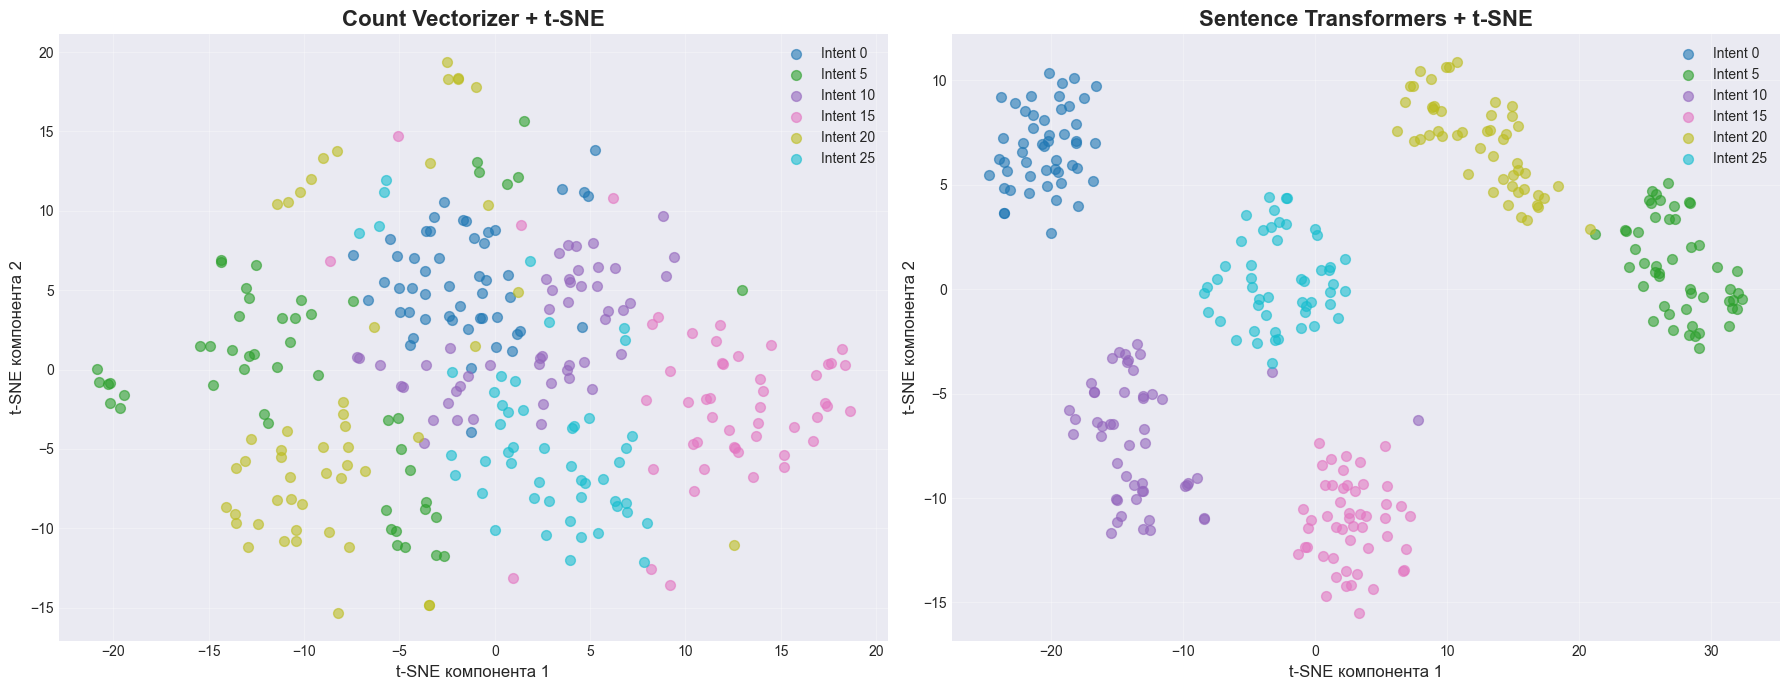

In [15]:
# Создаем визуализацию
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Цветовая палитра для классов
colors = plt.cm.tab10(np.linspace(0, 1, len(selected_labels)))

# График для Count Vectorizer
for i, label in enumerate(selected_labels):
    mask = y_viz == label
    axes[0].scatter(X_viz_counts_2d[mask, 0], X_viz_counts_2d[mask, 1], 
                   c=[colors[i]], label=f'Intent {label}', alpha=0.6, s=50)

axes[0].set_title('Count Vectorizer + t-SNE', fontsize=16, fontweight='bold')
axes[0].set_xlabel('t-SNE компонента 1', fontsize=12)
axes[0].set_ylabel('t-SNE компонента 2', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# График для Sentence Transformers
for i, label in enumerate(selected_labels):
    mask = y_viz == label
    axes[1].scatter(X_viz_sentences_2d[mask, 0], X_viz_sentences_2d[mask, 1], 
                   c=[colors[i]], label=f'Intent {label}', alpha=0.6, s=50)

axes[1].set_title('Sentence Transformers + t-SNE', fontsize=16, fontweight='bold')
axes[1].set_xlabel('t-SNE компонента 1', fontsize=12)
axes[1].set_ylabel('t-SNE компонента 2', fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 🔍 Что мы видим?

**Count Vectorizer:**
- Тексты из одного интента могут быть разбросаны по всему пространству
- Группировка менее выраженная
- Некоторые кластеры перекрываются

**Sentence Transformers:**
- Тексты из одного интента формируют более плотные кластеры
- Кластеры лучше разделены между собой
- Тексты с похожим смыслом находятся ближе друг к другу

Это показывает, что **Sentence Transformers лучше улавливает семантическое сходство** между текстами!


## 7. Классификация с Sentence Transformers 🎯


Теперь используем эмбеддинги Sentence Transformers для обучения классификатора.


### 7.1. Получение эмбеддингов для всех данных


In [16]:
# Модель уже загружена выше (sentence_model)
# Получаем эмбеддинги для обучающей выборки
print("🔄 Создаем эмбеддинги для обучающей выборки...")
X_train_embeddings = sentence_model.encode(X_train, show_progress_bar=True)

# Получаем эмбеддинги для тестовой выборки
print("🔄 Создаем эмбеддинги для тестовой выборки...")
X_test_embeddings = sentence_model.encode(X_test, show_progress_bar=True)

print("✅ Эмбеддинги созданы!")
print(f"Размер обучающей матрицы: {X_train_embeddings.shape}")
print(f"Размер тестовой матрицы: {X_test_embeddings.shape}")


🔄 Создаем эмбеддинги для обучающей выборки...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

🔄 Создаем эмбеддинги для тестовой выборки...


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Эмбеддинги созданы!
Размер обучающей матрицы: (10003, 384)
Размер тестовой матрицы: (3080, 384)


### 7.2. Обучение модели


In [17]:
# Создаем и обучаем логистическую регрессию на эмбеддингах
lr_embeddings = LogisticRegressionCV(random_state=42)
lr_embeddings.fit(X_train_embeddings, y_train)

print("✅ Модель обучена!")


✅ Модель обучена!


### 7.3. Оценка качества


In [18]:
# Делаем предсказания
y_pred_embeddings = lr_embeddings.predict(X_test_embeddings)

# Считаем accuracy
accuracy_embeddings = accuracy_score(y_test, y_pred_embeddings)

print("📊 Результаты Sentence Transformers + Логистическая регрессия:")
print(f"Accuracy на тестовой выборке: {accuracy_embeddings:.4f} ({accuracy_embeddings*100:.2f}%)")
print(f"\nЭто означает, что модель правильно классифицировала {int(accuracy_embeddings*len(y_test))} из {len(y_test)} запросов")


📊 Результаты Sentence Transformers + Логистическая регрессия:
Accuracy на тестовой выборке: 0.9321 (93.21%)

Это означает, что модель правильно классифицировала 2871 из 3080 запросов


### 7.4. Примеры предсказаний на новых текстах


In [19]:
# Попробуем классифицировать новые запросы
new_queries = [
    "I need to activate my new credit card",
    "What's my current balance?",
    "How can I transfer money to another account?",
    "My card was stolen, what should I do?",
    "I want to change my PIN code"
]

print("🔮 Предсказания для новых запросов:\n")

# Получаем эмбеддинги для новых запросов
new_embeddings = sentence_model.encode(new_queries)

# Делаем предсказания
predictions = lr_embeddings.predict(new_embeddings)

for query, pred in zip(new_queries, predictions):
    print(f"Запрос: \"{query}\"")
    print(f"Предсказанный интент: {pred}")
    print()


🔮 Предсказания для новых запросов:

Запрос: "I need to activate my new credit card"
Предсказанный интент: 0

Запрос: "What's my current balance?"
Предсказанный интент: 5

Запрос: "How can I transfer money to another account?"
Предсказанный интент: 65

Запрос: "My card was stolen, what should I do?"
Предсказанный интент: 41

Запрос: "I want to change my PIN code"
Предсказанный интент: 21



## 9. Сравнение всех подходов 📈


### 9.1. Сравнение метрик


📊 Сравнение всех подходов:

          Подход  Accuracy  Размер вектора  Правильно классифицировано
Count Vectorizer  0.885714            1461                        2728
   MiniLM (384d)  0.932143             384                        2871


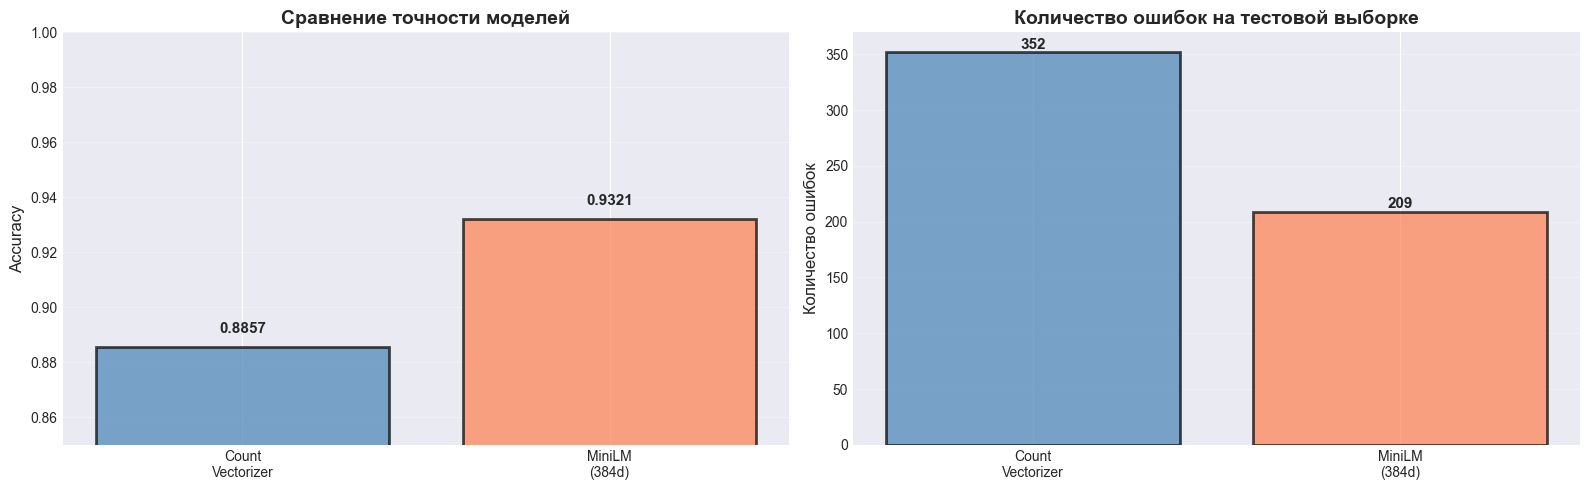


💡 Улучшения:
   MiniLM vs Count Vectorizer: +5.24%


In [21]:
# Создаем таблицу сравнения трех подходов
comparison_df = pd.DataFrame({
    'Подход': ['Count Vectorizer', 'MiniLM (384d)'],
    'Accuracy': [accuracy_counts, accuracy_embeddings],
    'Размер вектора': [len(count_vectorizer.vocabulary_), X_train_embeddings.shape[1]],
    'Правильно классифицировано': [
        int(accuracy_counts * len(y_test)),
        int(accuracy_embeddings * len(y_test)),
    ]
})

print("📊 Сравнение всех подходов:\n")
print(comparison_df.to_string(index=False))

# Визуализируем сравнение
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# График 1: Сравнение Accuracy
approaches = ['Count\nVectorizer', 'MiniLM\n(384d)']
accuracies = [accuracy_counts, accuracy_embeddings]
colors_bar = ['steelblue', 'coral', 'mediumseagreen']

bars = axes[0].bar(approaches, accuracies, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Сравнение точности моделей', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.85, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, (approach, acc) in enumerate(zip(approaches, accuracies)):
    axes[0].text(i, acc + 0.005, f'{acc:.4f}', ha='center', fontsize=11, fontweight='bold')

# График 2: Количество ошибок
errors = [len(y_test) - int(accuracy_counts * len(y_test)),
          len(y_test) - int(accuracy_embeddings * len(y_test)),
          ]

bars2 = axes[1].bar(approaches, errors, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Количество ошибок', fontsize=12)
axes[1].set_title('Количество ошибок на тестовой выборке', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, (approach, err) in enumerate(zip(approaches, errors)):
    axes[1].text(i, err + 3, f'{err}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Вычисляем улучшения
improvement_mini_vs_counts = (accuracy_embeddings - accuracy_counts) / accuracy_counts * 100

print("\n💡 Улучшения:")
print(f"   MiniLM vs Count Vectorizer: +{improvement_mini_vs_counts:.2f}%")


### 9.3. Когда какой подход выбрать?


#### Выбирайте **Count Vectorizer**, если:

✅ У вас небольшой датасет (несколько тысяч примеров)  
✅ Важна **скорость обучения** и низкие вычислительные требования  
✅ Нужна **интерпретируемость** (понять, какие слова важны)  
✅ Тексты хорошо различаются по ключевым словам  
✅ Нет GPU для обучения  
✅ Работаете на простом компьютере/ноутбуке

#### Выбирайте **Sentence Transformers**, если:

✅ Нужен баланс между скоростью и качеством  
✅ Работаете преимущественно с английским языком  
✅ Важна точность, но ресурсы ограничены  
✅ Тексты содержат синонимы и перефразировки  
✅ Можно подождать чуть дольше ради лучшего качества  
✅ Хотите начать с трансформеров без больших затрат


#### Общие рекомендации:

💡 **Начните с Count Vectorizer** для быстрого прототипа и базового качества  
💡 **Переходите на MiniLM**, если нужна лучшая точность при умеренных ресурсах  
💡 **Комбинируйте подходы**: можно использовать эмбеддинги как дополнительные признаки  
💡 **Экспериментируйте**: попробуйте все три подхода и выберите лучший для вашей задачи

#### Сводная таблица:

| Критерий | Count Vectorizer | SentenceTransformers
|----------|------------------|---------|
| **Скорость** | ⚡⚡⚡ Очень быстро | ⚡⚡ Быстро |
| **Точность** | ⭐⭐ Средняя | ⭐⭐⭐ Хорошая | 
| **Ресурсы** | 💻 Минимальные | 💻💻 Средние | 
| **Многоязычность** | ❌ Нет | ⚠️ Ограничена | 
| **Размер модели** | - | ~90MB |


## 10. Выводы 🎓


В этом ноутбуке мы:

### ✅ Изучили задачу классификации интентов
- Познакомились с датасетом Banking77 (13,083 запросов, 77 классов)
- Поняли, что такое интенты и почему они важны для чат-ботов

### ✅ Реализовали классический подход
- **Count Vectorizer (Bag of Words)**: простой и быстрый метод
- Подсчет частоты слов для представления текста
- Accuracy: ~88.9%

### ✅ Реализовали современные подходы с трансформерами
- **MiniLM (all-MiniLM-L6-v2)**: компактная модель для семантических эмбеддингов
  

### ✅ Визуализировали эмбеддинги
- Применили t-SNE для снижения размерности всех трех подходов
- Увидели, что трансформерные модели лучше группируют тексты по смыслу

### ✅ Сравнили все подходы
- Построили таблицы и графики сравнения
- Определили, когда использовать каждый подход
- Увидели примеры, где семантическое понимание критично

### 📊 Итоговое сравнение:

| Подход | Accuracy | Скорость | Ресурсы | Применение |
|--------|----------|----------|---------|------------|
| Count Vectorizer | ⭐⭐ | ⚡⚡⚡ | 💻 | Быстрое прототипирование |
| MiniLM | ⭐⭐⭐ | ⚡⚡ | 💻💻 | Баланс качества и скорости |
| E5 Large | ⭐⭐⭐⭐ | ⚡ | 💻💻💻 | Production, максимальная точность |

### 🎯 Главный вывод:

**Выбор подхода зависит от ваших приоритетов:**
- Нужна **скорость** → Count Vectorizer
- Нужен **баланс** → SentenceTransformers

### 🚀 Дальнейшие шаги:

1. **Попробуйте другие модели** sentence-transformers (например, multi-qa-MiniLM-L6-cos-v1, paraphrase-multilingual-mpnet-base-v2)
2. **Экспериментируйте с параметрами** Count Vectorizer (n-grams, max_features, TF-IDF)
3. **Используйте другие классификаторы** (SVM, Random Forest, XGBoost, нейронные сети)
4. **Попробуйте fine-tuning** предобученной модели на вашем датасете для еще лучшей точности
5. **Комбинируйте подходы**: используйте эмбеддинги как дополнительные признаки
6. **Примените к своим данным** - создайте классификатор для своей задачи!

---

**Спасибо за внимание! Успехов в машинном обучении! 🎉**
